# Modele baseline do predykcji temperatury

Chcemy zacząć od prostych modeli pokazujące oczywiste rzeczy na temat pogody

1. Pogoda jutro będzie taka sama jak dzisiaj
2. Pogoda zawsze jest jakąś średnią z aktualnego miesiąca
3. Pogoda składa się z trendu globalnego (dopasowania regresji), trendu sezonowego (pora roku), lokalnego (dzień vs noc) i z losowego szumu

(ponieważ danie nie mają wyraźnego trendu globalnego i ostatecznie zdecydowaliśmy się na predykcje dla dnia i nocy osobno, to 2 i 3 będą bardzo podobne)

Dla każdego modelu baseline zapisujemy RMSE, MAE, R2 na zbiorze testowym
Dodatkowo:
- dla których pór roku się bardziej mylimy a dla których mniej
- wykres "błąd vs miesiąc"

Zbiór testowy to ostatni rok w danych

```txt
--- Baseline 1: Persistence ---
[Day  ] RMSE: 2.94, MAE: 2.26, R2: 0.87
[Night] RMSE: 3.04, MAE: 2.38, R2: 0.81

--- Baseline 2: Monthly Average ---
[Day  ] RMSE: 4.16, MAE: 3.45, R2: 0.75
[Night] RMSE: 3.78, MAE: 3.03, R2: 0.70

--- Baseline 3: Decomposition (+Noise) ---
[Day  ] RMSE: 5.56, MAE: 4.43, R2: 0.55
[Night] RMSE: 5.14, MAE: 4.12, R2: 0.45
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn-v0_8-whitegrid')

DATA_DIR = Path('data')

df = pd.read_csv(DATA_DIR / 'combined.csv', parse_dates=['time'], index_col='time')

In [2]:
def get_targets(df_raw):
    temp = df_raw[['temp']].copy()

    # Definicja okresów
    mask_day = (temp.index.hour >= 6) & (temp.index.hour <= 17)
    mask_night = (temp.index.hour >= 18) | (temp.index.hour <= 5)

    # 1. Target Dnia (Średnia 06:00 - 17:00 przypisana do daty)
    target_day = temp.loc[mask_day, 'temp'].resample('D').mean()
    target_day.name = 'target_temp_day'

    # 2. Target Nocy (Średnia 18:00 - 05:00 przypisana do daty wieczora)
    # Przesuwamy -6h, żeby noc 1/2 stycznia liczyła się do 1 stycznia
    temp_night_shifted = temp.loc[mask_night].copy()
    temp_night_shifted.index = temp_night_shifted.index - pd.Timedelta(hours=6)
    target_night = temp_night_shifted['temp'].resample('D').mean()
    target_night.name = 'target_temp_night'

    return target_day, target_night


def prepare_data(df):
    series_day_target, series_night_target = get_targets(df)
    df_daily = pd.DataFrame(
            {"temp_day_current": series_day_target, "temp_night_current": series_night_target}
        )

    # Drop days with incomplete data
    df_daily = df_daily.dropna()

    # Create Targets (Shift -1 for Tomorrow)
    df_daily["target_temp_day"] = df_daily["temp_day_current"].shift(-1)
    df_daily["target_temp_night"] = df_daily["temp_night_current"].shift(-1)
    df_daily = df_daily.dropna()

    df_daily["month"] = df_daily.index.month
    return df_daily

In [3]:
def show_results(
    y_true_day, y_pred_day, y_true_night, y_pred_night, model_name, test_df
):
    print(f"\n--- {model_name} ---")

    # Calculate metrics
    metrics = {}
    for period, y_true, y_pred in [
        ("Day", y_true_day, y_pred_day),
        ("Night", y_true_night, y_pred_night),
    ]:
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        metrics[period] = {"RMSE": rmse, "MAE": mae, "R2": r2}
        print(f"[{period:<5}] RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

    # Calculate errors for plotting
    test_copy = test_df.copy()
    test_copy["error_day"] = y_true_day - y_pred_day
    test_copy["error_night"] = y_true_night - y_pred_night

    # Plot Error vs Month
    fig, ax = plt.subplots(figsize=(10, 5))
    monthly_mae_day = test_copy.groupby("month")["error_day"].apply(
        lambda x: np.mean(np.abs(x))
    )
    monthly_mae_night = test_copy.groupby("month")["error_night"].apply(
        lambda x: np.mean(np.abs(x))
    )

    ax.plot(monthly_mae_day.index, monthly_mae_day.values, label="Day MAE", marker="o")
    ax.plot(
        monthly_mae_night.index, monthly_mae_night.values, label="Night MAE", marker="s"
    )

    ax.set_title(f"{model_name}: Mean Absolute Error by Month")
    ax.set_xlabel("Month")
    ax.set_ylabel("MAE")
    ax.set_xticks(range(1, 13))
    ax.legend()
    plt.tight_layout()
    plt.show()

In [4]:
# Data Preparation
df_daily = prepare_data(df)

# Split (Test = Last 365 Days)
last_timestamp = df_daily.index.max()

cutoff_date = last_timestamp - pd.Timedelta(days=365)

train = df_daily[df_daily.index <= cutoff_date]
test = df_daily[df_daily.index > cutoff_date].copy()

print(f"Train set: {train.index.min().date()} to {train.index.max().date()}")
print(f"Test set: {test.index.min().date()} to {test.index.max().date()}")

Train set: 2018-01-01 to 2024-12-29
Test set: 2024-12-30 to 2025-12-29


#### 1. Tomorrow will be the same as today (Persistence)


--- Baseline 1: Persistence ---
[Day  ] RMSE: 2.94, MAE: 2.26, R2: 0.87
[Night] RMSE: 3.04, MAE: 2.38, R2: 0.81


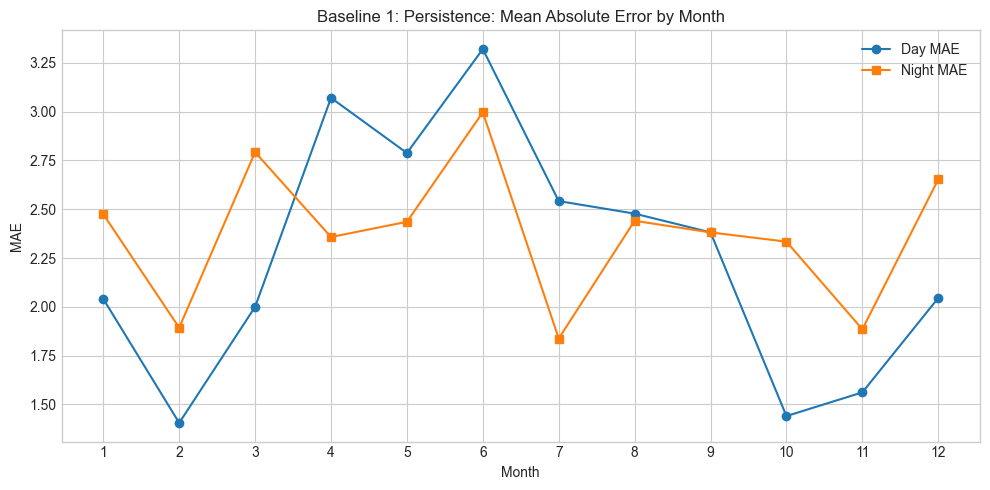

In [5]:

# 1. Tomorrow will be the same as today (Persistence)

pred_day_persistence = test["temp_day_current"]
pred_night_persistence = test["temp_night_current"]

show_results(
test["target_temp_day"],
pred_day_persistence,
test["target_temp_night"],
pred_night_persistence,
"Baseline 1: Persistence",
test,
)


#### 2. Monthly Average (Climatology)


--- Baseline 2: Monthly Average ---
[Day  ] RMSE: 4.16, MAE: 3.45, R2: 0.75
[Night] RMSE: 3.78, MAE: 3.03, R2: 0.70


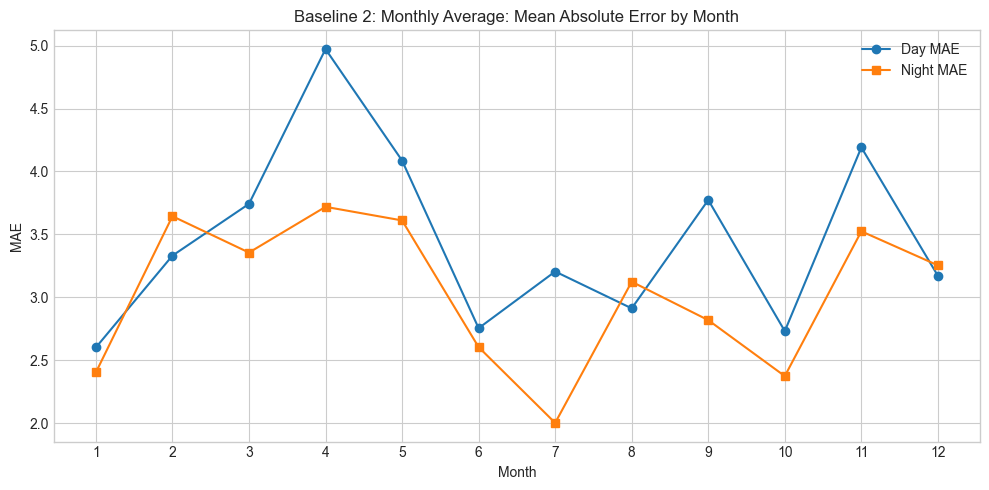

In [6]:
# 2. Monthly Average (Climatology)

monthly_means_day = train.groupby("month")["temp_day_current"].mean()
monthly_means_night = train.groupby("month")["temp_night_current"].mean()

pred_day_monthly = test["month"].map(monthly_means_day)
pred_night_monthly = test["month"].map(monthly_means_night)

show_results(
    test["target_temp_day"],
    pred_day_monthly,
    test["target_temp_night"],
    pred_night_monthly,
    "Baseline 2: Monthly Average",
    test,
)

In [7]:
def predict_decomposition(train_df, test_df, target_col, add_noise=True):
    """
    Decomposes the time series into Trend + Seasonality + Residuals.
    Predicts: Trend(test) + Seasonality(test) + RandomNoise(train_std).
    """

    # 1. Global Trend (Dopasowujemy regresję liniową do danych treningowych)
    X_train = train_df.index.map(pd.Timestamp.toordinal).values.reshape(
        -1, 1
    )  # Convert dates to ordinal numbers for regression
    y_train = train_df[target_col].values

    model_trend = LinearRegression()
    model_trend.fit(X_train, y_train)
    trend_train = model_trend.predict(X_train)

    # 2. Seasonality (Po odjęciu trendu, wyliczamy średnią dla każdego dnia roku)
    detrended_train = y_train - trend_train
    temp_train = pd.DataFrame(  # Create a temporary DF to group by day_of_year
        {"detrended": detrended_train, "day_of_year": train_df.index.dayofyear}
    )
    seasonal_profile = temp_train.groupby("day_of_year")["detrended"].mean()
    seasonality_train = train_df.index.dayofyear.map(seasonal_profile).fillna(0)

    # 3. Noise Analysis
    residuals_train = detrended_train - seasonality_train
    noise_std = residuals_train.to_numpy().std()

    # ================= PREDICTION =================

    # 1. Predict Trend for Test
    X_test = test_df.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    pred_trend = model_trend.predict(X_test)

    # 2. Predict Seasonality for Test
    # Map the learned seasonal profile to test dates
    pred_seasonality = test_df.index.dayofyear.map(seasonal_profile)

    # Handle missing keys (should not be present in the full dataset)
    if pred_seasonality.isna().any():
        pred_seasonality = pred_seasonality.fillna(0)

    # 3. Add Random Noise
    prediction = pred_trend + pred_seasonality
    if add_noise:
        # Generate random noise with the same std as training residuals
        np.random.seed(42)
        random_noise = np.random.normal(0, noise_std, size=len(test_df))
        prediction += random_noise

    return prediction


#### 3. Decomposition (Trend + Season + Noise)


--- Baseline 3: Decomposition (+Noise) ---
[Day  ] RMSE: 5.56, MAE: 4.43, R2: 0.55
[Night] RMSE: 5.14, MAE: 4.12, R2: 0.45


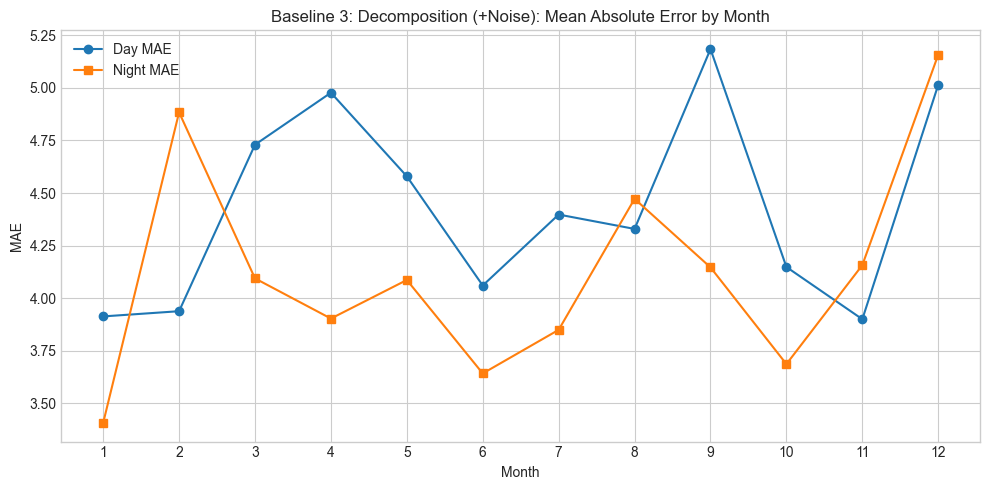

In [8]:
# 3. Decomposition (Trend + Season + Noise)

pred_day_decomp = predict_decomposition(train, test, "temp_day_current", add_noise=True)
pred_night_decomp = predict_decomposition(
    train, test, "temp_night_current", add_noise=True
)

show_results(
    test["target_temp_day"],
    pred_day_decomp,
    test["target_temp_night"],
    pred_night_decomp,
    "Baseline 3: Decomposition (+Noise)",
    test,
)